Noise removal - PCA
* Using Greg's code - https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/3.clustering-pca/0.cp_pca_clustering_analysis.ipynb

Reading the normalized value dfs of standard CP plate and the chromalive plate 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle as pk


### PCA analysis

In [31]:
# A function to take a file name of a dataframe as input and give out the cumulative PCA as output based on the specified number of components 
def transform_pca(file_name, no_of_pcs):
        #file_name is a string
        #no_of_pcs takes an integer as an input and will be used as the number of components for the PCA analysis 
    df = pd.read_csv(file_name, compression='gzip')
    #Removing metadata 
    std_features_list = [c for c in df.columns if not c.startswith('Metadata')]
    std_metadata_list = [c for c in df.columns if c.startswith('Metadata')]
    features_df = df[std_features_list]
    metadata_df  = df[std_metadata_list]
    #Filling NAs
    features_nafilled_df = features_df.fillna('0')
    #removing infinity values in the df 
    features_nafilled_df.replace([np.inf, -np.inf], 0, inplace=True)
  

    #perform a scaling function to get the feature values in the dataframe to a similar range of values 
    scaler = StandardScaler()
    scaled_agg = scaler.fit_transform(features_nafilled_df)
    df_scaled = pd.DataFrame(data = scaled_agg, columns = ['feat_' + str(x) for x in range(1,features_nafilled_df.shape[1]+1)])
    df_scaled_metadata = pd.concat([df_scaled, metadata_df], axis=1)
    df_scaled_metadata.to_csv(f"{file_name[:-4]}_scaled_features.csv", index=False)
    
    #lets extract features with the most variance in our dataset
    pca = PCA(n_components=no_of_pcs)
    pc = pca.fit_transform(scaled_agg)
    pk.dump(pc, open(f"{file_name[:-4]}_pca.pkl", "wb"))
    df_pc = pd.DataFrame(data = pc, columns = ['PC' + str(x) for x in range(1,no_of_pcs+1)])
    df_pc_metadata = pd.concat([df_pc, metadata_df], axis=1)
    df_pc_metadata.to_csv(f"{file_name[:-4]}_pc.csv", index=False)
   
    return pca

#### Generating the PCA dataframes with the normalized values from all the batches

In [49]:
batch1_pca = transform_pca('C:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122250_normalized.csv',no_of_pcs=150)
batch1_tocris_pca = transform_pca('C:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122246_normalized.csv',no_of_pcs=150)
batch2_pca = transform_pca('C:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122247_normalized.csv',no_of_pcs=150)
batch3_pca = transform_pca('C:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122248_normalized.csv',no_of_pcs=150)
batch5_pca = transform_pca('C:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122249_normalized.csv',no_of_pcs=150)

#### Comparison graphs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


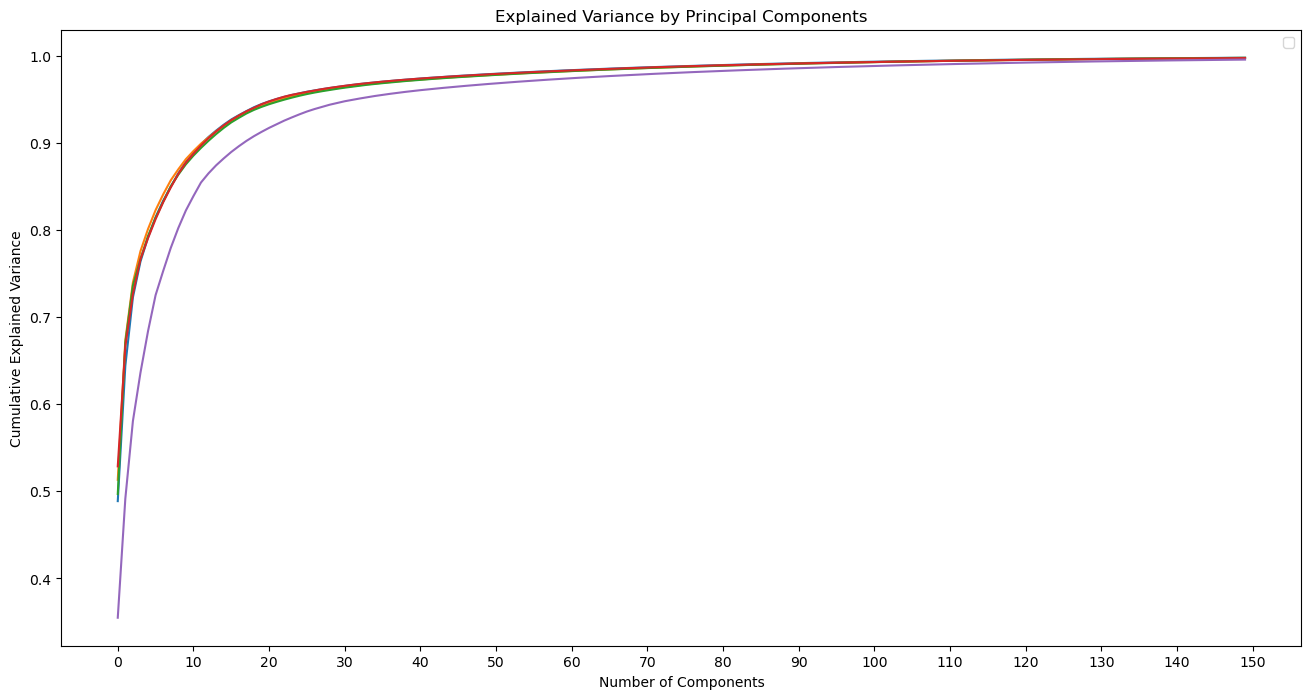

In [64]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(16, 8))
fig = plt.plot(np.cumsum(batch1_pca.explained_variance_ratio_))
plt.plot(np.cumsum(batch1_tocris_pca.explained_variance_ratio_))
plt.plot(np.cumsum(batch2_pca.explained_variance_ratio_))
plt.plot(np.cumsum(batch3_pca.explained_variance_ratio_))
plt.plot(np.cumsum(batch5_pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.xticks(np.arange(0, 151, step=10))
plt.legend()
plt.show()

### Copairs on the noise removed data 

In [41]:
from copairs.map import run_pipeline
import logging
from copairs.map import aggregate

### Analysis - Plate wise with respect to control DMSO wells
#### Defining parameters to compute map

In [23]:
pert_col = "Metadata_broad_sample"
control_col = "Metadata_control_type"

In [24]:
pos_sameby = [pert_col]
pos_diffby = []

neg_sameby = []
neg_diffby = [control_col]
null_size = 10000

In [54]:
aggregated = {}

In [116]:
def copairs_batches(filename):
    df = pd.read_csv(filename)
    name = filename[-28:-4]
    print(name)
    metadata_names = [c for c in df.columns if c.startswith("Metadata")]
    feature_names = [c for c in df.columns if not c.startswith("Metadata")]
    feats = df[feature_names].values
    dframe = df[metadata_names]
    dframe[control_col].fillna("trt", inplace=True)
    result = run_pipeline(
        dframe, feats, pos_sameby, pos_diffby, neg_sameby, neg_diffby, null_size
    )
    
    result.to_csv(f"{filename[:-4]}_Result_Negcon_wrt_Controls.csv")
    
    aggregated[name] = aggregate(result, sameby=pos_sameby, threshold=0.05)
    aggregated[name].to_csv(f"{filename[:-4]}_Aggregate_result_Negcon_wrt_Controls.csv")
    return aggregated[name]

In [117]:
batch1_stdCP_copairs = copairs_batches('c:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122250_normalized_pc.csv')

BR00122250_normalized_pc


C:\Users\ssivagur\AppData\Local\Temp\ipykernel_21704\1642055774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
batch1_tocris_copairs = copairs_batches('c:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122246_normalized_pc.csv')

BR00122246_normalized_pc


C:\Users\ssivagur\AppData\Local\Temp\ipykernel_21704\1642055774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [119]:
batch2_copairs = copairs_batches('c:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122247_normalized_pc.csv')

BR00122247_normalized_pc


C:\Users\ssivagur\AppData\Local\Temp\ipykernel_21704\1642055774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [120]:
batch3_copairs = copairs_batches('c:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122248_normalized_pc.csv')

BR00122248_normalized_pc


C:\Users\ssivagur\AppData\Local\Temp\ipykernel_21704\1642055774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
batch5_copairs = copairs_batches('c:\\Users\\ssivagur\\Documents\\Projects\\Cell_painting_projects\\CDoT\\BR00122249_normalized_pc.csv')

BR00122249_normalized_pc


C:\Users\ssivagur\AppData\Local\Temp\ipykernel_21704\1642055774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [104]:
renamed_dict = {}
for i in list(aggregated.keys()):
    name = i[0:10]
    aggregated[i] = aggregated[i].rename(columns = {'average_precision':'average_precision'+ i})
    renamed_dict[i] = aggregated[i]

BR00122246
BR00122247
BR00122248
BR00122249
BR00122250
